In [1]:
# September 2021

# Кластеризация

In [2]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Введение

В этот раз мы займемся двумя вопросами: кластеризацией и факторным анализом. Кластеризация близко подходит к методу k ближайщих соседей, а факторный анализ предполагает анализ главных компонент. 

Кластеризация нацелена на разбиение данных по группам. Мы проводили нечто аналогичное, когда для логистической регрессии разбивали данные на группы. Отличие в том, что мы использовали квантили только на одномерных данных. В данном же случае мы воспользуемся более продвинутыми способами, когда мы разбиваем данные на группы с позиции многомерных данных. 

Суть кластеризации в следующем. Произвольно назначаем центры. Далее считаем расстояние от ближайших точек к этим центрам на основании квадратичного расстояния. Например, у нас четыре центра. До каждого считаем расстояние. Какое меньше, к такому и относим. Это образует кластеры. В каждом кластере считаем среднее – это наш новый центр. Пересчитываем расстояния, формируем кластеры. 

Если есть выбросы в данных, то применяется Density-Based Spatial Clustering of Applications with Noise.

Если значения признаков непрерывные, то в качестве меры расстояния между объектами обычно используется расстояние Евклида, а если категориальные, то может использоваться расстояние Хэмминга.

## Рекомендуемая литература

1) Сара Бослаф Статистика для всех
2) П. Брюс Практическая статистика для специалистов Data Science
3) С. Рашка, В. Мирджалили Python и машинное обучение
4) "Изучаем Pandas" Майкл Хейдт, Артем Груздев (обязательно второе издание). Лушее описание логистической регрессии из тех, что я читал.

Рекомендуемые книги по математике см. [здесь](https://medium.com/data-science-with-ruslan-nazarov/книги-по-data-science-и-математике-для-начинающих-6257214d82d7)

Видео-версия находится [здесь](https://youtu.be/dVrpNqpteVQ).

Дополнительный полезный код, который может быть применен в том числе к задаче статистического обследования данных, можно также найти в главе 7.


# Получение данных

In [3]:
data = pd.read_csv('D:/Data Science/Проекты/Metod_Goodreads/git_goodreads/gd_augmentation.csv', dtype = {'decade':'object','quarter':'object', 'tra_co':'object', 'multivolume':'object'}) 

In [4]:
# сделаем копию данных
# удалим признаки, которые не будем рассматривать в этом исследовании

db = data.copy()
db = db.drop(['title', 'language_code'], axis=1)

In [5]:
db.head(5) 

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,4.57,652,2095690,27591,2000,3,1,1,39,-0.166667,0.166667
1,4.49,870,2153167,29221,2000,3,1,1,42,0.000000,0.000000
2,4.42,352,6333,244,2000,4,0,1,40,0.000000,0.000000
3,4.56,435,2339585,36325,2000,2,1,1,41,0.000000,0.000000
4,4.78,2690,41428,164,2000,3,1,1,34,0.000000,0.000000


# Подготовка данных

Нас будет интересовать взаимосвязь средней оценки и количества страниц. Из обработки мы ограничимся только стандартизацией. 

In [6]:
from sklearn.preprocessing import QuantileTransformer

# делаем копию наших данных

db_scal = db.copy() 

# отбираем количественные признаки

col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count'] 

# датафрейм только с количественными признаками

features = db_scal[col] 

# вызываем и обучаем шкалировщик

scaler = QuantileTransformer(n_quantiles=10, random_state=42).fit(features.values) 

# преобразуем датафрейм с количественными признаками

features = scaler.transform(features.values) 

# возвращаем наши данные в исходный датафрейм

db_scal[col] = features 

In [7]:
db_scal 

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,0.934551,0.890296,0.939246,0.920679,2000,3,1,1,39,-0.166667,0.166667
1,0.922374,0.894333,0.940642,0.922618,2000,3,1,1,42,0.000000,0.000000
2,0.911720,0.620370,0.769191,0.737192,2000,4,0,1,40,0.000000,0.000000
3,0.933029,0.769608,0.945168,0.931069,2000,2,1,1,41,0.000000,0.000000
4,0.966514,0.928037,0.889363,0.683965,2000,3,1,1,34,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
10833,0.650794,0.836601,0.271772,0.350877,2000,4,1,1,48,0.000000,0.000000
10834,0.679012,0.889981,0.486284,0.511785,1980,4,0,0,27,0.700000,0.800000
10835,0.500000,0.736928,0.492427,0.597424,1990,3,0,1,14,0.000000,0.000000
10836,0.200000,0.767974,0.483960,0.667332,2000,1,0,0,11,-0.400000,0.600000


# Обучение

Надо помнить принцип: всегда ищи легкий путь. Сначала мы должны запустить кластеризацию на базовых настройках, произвольно выбрав кластеры. Часто используют 4-5 кластеров. Только после этого мы начнем диагностику модели.

Условия применения метода k средних:

1) кластеры имеют форму круга;

2) признаки должны быть шкалированы;

3) группы сбалансированы, то есть имеют примерно одинаковое количество наблюдений.

<AxesSubplot:xlabel='average_rating', ylabel='num_pages'>

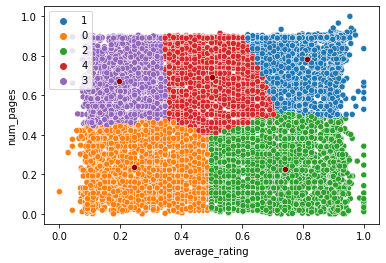

In [8]:
# копируем данные

db_k = db_scal.copy() 

# вызываем модель кластеризации

kmeans = KMeans(n_clusters=5, init='k-means++') 

# тренируем модель

kmeans.fit(db_k[['average_rating', 'num_pages']]) 

# предсказываем классы

y_kmeans = kmeans.predict(db_k[['average_rating', 'num_pages']]) 

# добавляем в наши данные указание на классы для каждого наблюдения

db_k['labels'] = kmeans.labels_.astype(str) 

# строим график с классами

sns.scatterplot(x = db_k['average_rating'], y = db_k['num_pages'], data=db_k, hue=db_k['labels']) 

# извлекаем центроиды из модели

centers = kmeans.cluster_centers_ 

# добавляем на график центроиды

sns.scatterplot(x = centers[: , 0], y = centers[: , 1], color = 'darkred') 

Обратите внимание, насколько ровно выглядят наши данные. Метод k средних всегда пытается объединить данные в классы-облака. Кроме того, у нас стандартизированные данные.

# Оценка модели

In [9]:
from sklearn.metrics import silhouette_score

In [10]:
features1 = db_k[['average_rating', 'num_pages']] 

# классы для наших данных

target = kmeans.labels_ 

In [11]:
# оценка плотности классов

silhouette_score(features, target) 

0.15022292855380792

Плотность должна быть от -1 до 1. Причем данные хорошо разделены, если значение близко к 1.

Есть много способов оценить модель кластеризации. Эти способы отличаются по наличию или отсутствию истинных, известных классов. Более подробно см. [здесь](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

# Диагностика модели

Главная проблема метода кластеризации - это определение количества классов. Подобрать такое количество можно с помощью графика локтя.

Text(0, 0.5, '$J(C_k)$')

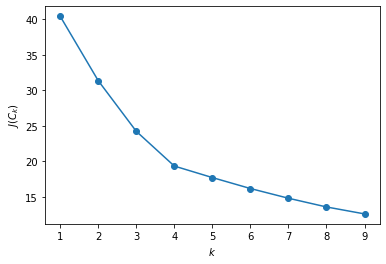

In [12]:
inertia = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k, random_state=42).fit(db_k[['average_rating', 'num_pages']])
    inertia.append(np.sqrt(k_means.inertia_))

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

На нашем графике линейность появляется после 5. Другими словами, каждая последующая точка после 5 - это просто смещение на одинаковый коэффициент. Для точек выше это не так, например у нас четка видна нелинейность перехода от 4 к 5. Поэтому выше мы могли применить 5.

In [13]:
# создаем датафрейм с предсказанными классами

output = pd.DataFrame(data=y_kmeans) 

# смотрим количество наблюдений в каждом классе

output[0].value_counts(ascending=False) 

0    2551
2    2450
1    2028
4    1955
3    1854
Name: 0, dtype: int64

Здесь мы видим, что группы распределены примерно одинаково.

Заметьте, здесь мы переходим к данным до шкалировки. Нам нужна шкалировка для обучения модели, но понять такие данные затруднительно. Поэтому мы возвращаемся к исходному формату, но с учетом полученных групп.

In [14]:
db_l = db
db_l['clus_membership'] = kmeans.labels_
db_l

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity,clus_membership
0,4.57,652,2095690,27591,2000,3,1,1,39,-0.166667,0.166667,1
1,4.49,870,2153167,29221,2000,3,1,1,42,0.000000,0.000000,1
2,4.42,352,6333,244,2000,4,0,1,40,0.000000,0.000000,1
3,4.56,435,2339585,36325,2000,2,1,1,41,0.000000,0.000000,1
4,4.78,2690,41428,164,2000,3,1,1,34,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10833,4.06,512,156,20,2000,4,1,1,48,0.000000,0.000000,1
10834,4.08,635,783,56,1980,4,0,0,27,0.700000,0.800000,1
10835,3.96,415,820,95,1990,3,0,1,14,0.000000,0.000000,4
10836,3.72,434,769,139,2000,1,0,0,11,-0.400000,0.600000,3


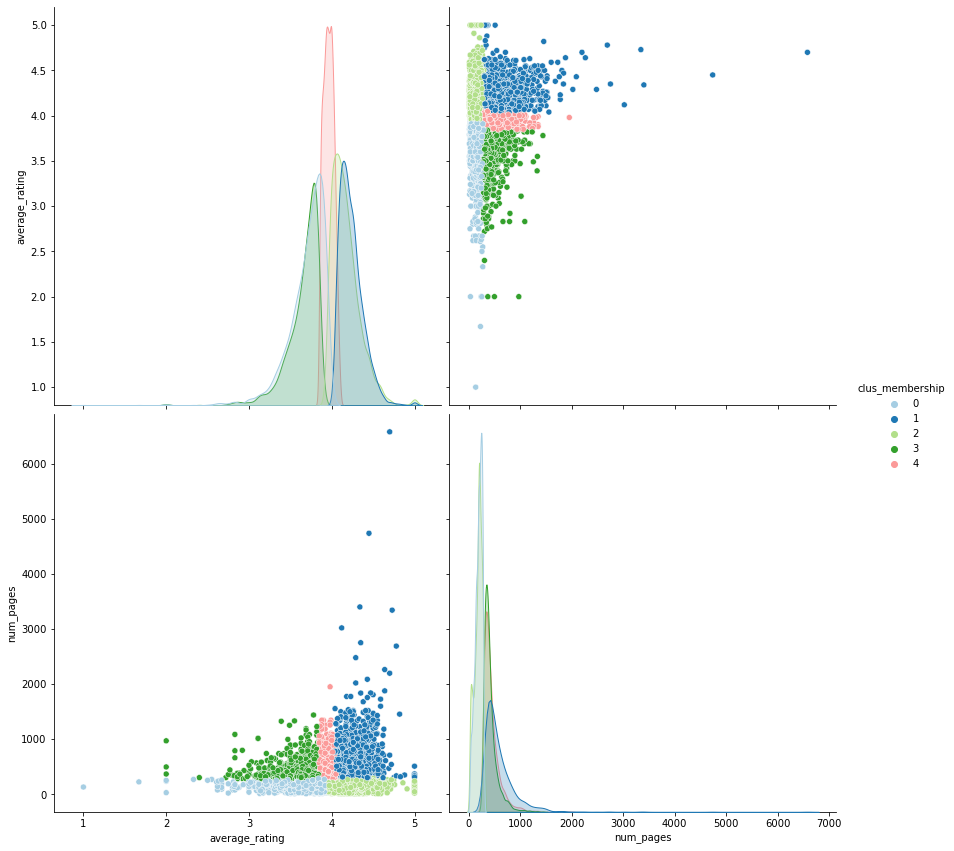

In [15]:
sns.set_palette("Paired")
sns.pairplot(db_l, hue='clus_membership', diag_kind='kde', vars=['average_rating', 'num_pages'], palette='Paired', height=6)

Как еще мы можем использовать кластеры? Например, мы можем сгруппировать наши исходные данные по этим кластерам и поискать зависимости.

In [16]:
db_l.groupby('clus_membership')['ratings_count', 'text_reviews_count'].mean()

<ipython-input-16-eda89babed5d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  db_l.groupby('clus_membership')['ratings_count', 'text_reviews_count'].mean()


,ratings_count,text_reviews_count
clus_membership,,
0,11002.957664,379.699726
1,29185.516272,785.207594
2,16082.851429,476.007347
3,17411.169903,549.629989
4,20416.513555,638.351407


# DBSCAN

Хорошое описание метода можно найти [здесь](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/)

Суть метода заключается в том, что данные разбиваются на кластеры, однако точки, которые далеко лежат от кластеров, помечаются как выбросы. 

In [17]:
db_scan = db.copy()

# загружаем шкалировщик

from sklearn.preprocessing import StandardScaler 

# отбираем количественные признаки

col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count'] 

# датафрейм только с количественными признаками

features = db_scan[col] 

# вызываем и обучаем шкалировщик

scaler = StandardScaler().fit(features.values) 

# преобразуем датафрейм с количественными признаками

features = scaler.transform(features.values) 

# возвращаем наши данные в исходный датафрейм

db_scan[col] = features 

In [18]:
db_scan

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity,clus_membership
0,2.125587,1.290424,18.244584,10.402361,2000,3,1,1,39,-0.166667,0.166667,1
1,1.854744,2.204297,18.749384,11.029475,2000,3,1,1,42,0.000000,0.000000,1
2,1.617755,0.032802,-0.105523,-0.118911,2000,4,0,1,40,0.000000,0.000000,1
3,2.091732,0.380744,20.386630,13.762613,2000,2,1,1,41,0.000000,0.000000,1
4,2.836552,9.833872,0.202705,-0.149690,2000,3,1,1,34,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10833,0.398959,0.703534,-0.159773,-0.205091,2000,4,1,1,48,0.000000,0.000000,1
10834,0.466670,1.219159,-0.154266,-0.191241,1980,4,0,0,27,0.700000,0.800000,1
10835,0.060404,0.296903,-0.153941,-0.176236,1990,3,0,1,14,0.000000,0.000000,4
10836,-0.752127,0.376552,-0.154389,-0.159308,2000,1,0,0,11,-0.400000,0.600000,3


In [19]:
# кластеризация методом DBSCAN

# загружаем модель

from sklearn.cluster import DBSCAN   

# вызываем модель

clus_dbscan = DBSCAN(eps=2, min_samples=10) 

# тренируем модель

scan_model = clus_dbscan.fit(db_scan[['average_rating', 'num_pages']]) 

In [20]:
scan_model.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

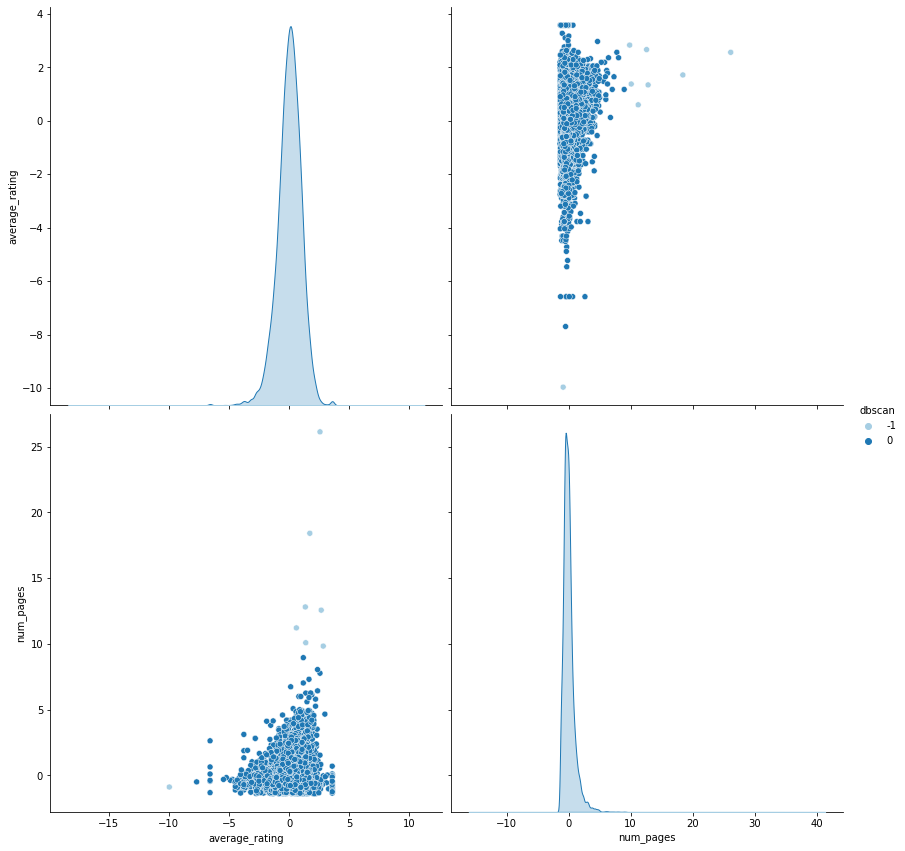

In [21]:
db_scan['dbscan'] = scan_model.labels_
sns.set_palette("Paired")
sns.pairplot(db_scan, hue='dbscan', diag_kind='kde', vars=['average_rating', 'num_pages'], palette='Paired', height=6)

Для этого алгоритма самое важное - правильно определить эпсилон, то есть минимальное количество точек, необходимых для формирования области. 

In [22]:
# получаем значение эпсилон

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(db_scan[['average_rating', 'num_pages']])
distances, indices = nbrs.kneighbors(db_scan[['average_rating', 'num_pages']])

In [23]:
distances

array([[0.        , 0.07513325],
       [0.        , 0.02515245],
       [0.        , 0.00419207],
       ...,
       [0.        , 0.00419207],
       [0.        , 0.00838415],
       [0.        , 0.        ]])

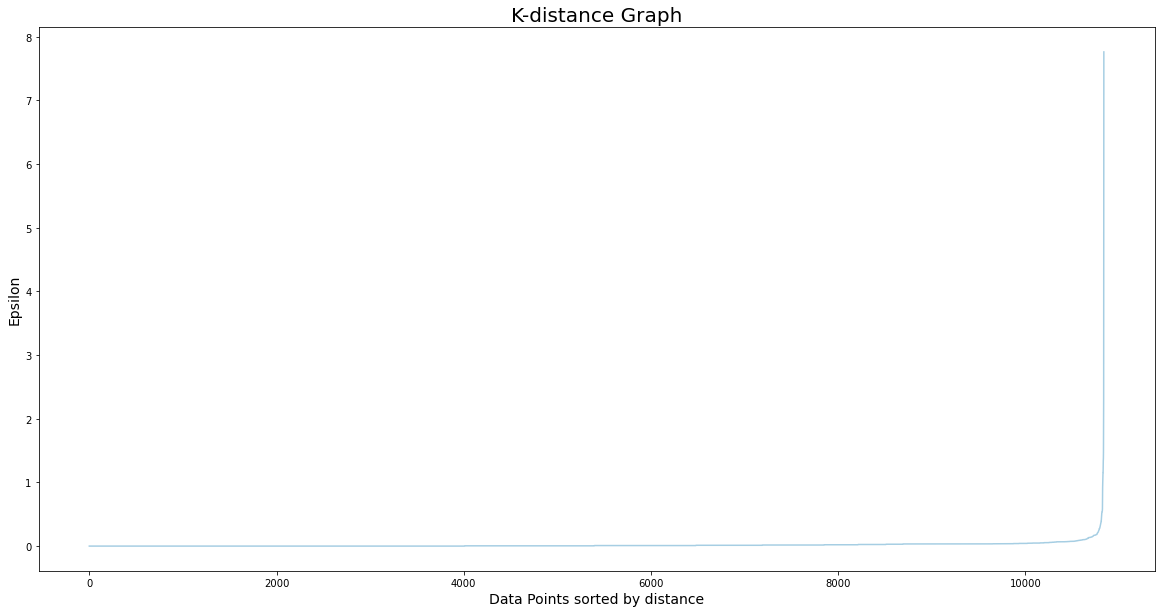

In [24]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Этот график позволяет определить эпсилон для DBSCAN.

# К ближайщих соседей

Применение k средних предполагает, что мы решаем задачу кластеризации. В свою очередь k ближайших соседей решает задачу классификации.

## Нахождение ближайщих соседей наблюдения

In [25]:
from sklearn.neighbors import NearestNeighbors 

In [26]:
# копируем исходные данные

db_n = db_scal.copy() 

# тренируем модель

nearest_neighbors = NearestNeighbors(n_neighbors=2).fit(db_n) 

In [27]:
# создаем новый признак

new_observation = [0.965, 0.745, 0.645, 0.812, 2000, 4, 1, 1, 42, 0.7, 0.8] 

In [28]:
# получаем класс для нового признака

distances, indices = nearest_neighbors.kneighbors([new_observation]) 

In [29]:
indices

array([[6970, 5794]], dtype=int64)

Здесь мы получаем индекс двух наблюдений, которые находятся ближе всего к заданному нами.

## k ближайших соседей

In [30]:
from sklearn.neighbors import KNeighborsClassifier 
db_nk = db.copy() 

In [31]:
# группы, на которые мы разобьем среднюю оценку

bins = [0, 4, 5] 

# название этих групп

groups_names = ['0', '1'] 

# проводим разбиение на группы

db_nk['rating_groups'] = pd.cut(db['average_rating'], bins, labels=groups_names, right=True).astype('int64') 

# удаляем количественный признак, на основании которого построили бинарный

db_nk = db_nk.drop(['average_rating', 'clus_membership'], axis=1) 

In [32]:
db_nk

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity,rating_groups
0,652,2095690,27591,2000,3,1,1,39,-0.166667,0.166667,1
1,870,2153167,29221,2000,3,1,1,42,0.000000,0.000000,1
2,352,6333,244,2000,4,0,1,40,0.000000,0.000000,1
3,435,2339585,36325,2000,2,1,1,41,0.000000,0.000000,1
4,2690,41428,164,2000,3,1,1,34,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
10833,512,156,20,2000,4,1,1,48,0.000000,0.000000,1
10834,635,783,56,1980,4,0,0,27,0.700000,0.800000,1
10835,415,820,95,1990,3,0,1,14,0.000000,0.000000,0
10836,434,769,139,2000,1,0,0,11,-0.400000,0.600000,0


In [33]:
col = ['num_pages', 'ratings_count', 'text_reviews_count']
features = db_nk[col]
scaler = QuantileTransformer(n_quantiles=10, random_state=42).fit(features.values)
features = scaler.transform(features.values)
db_nk[col] = features

In [34]:
# признаки

X = db_nk.drop('rating_groups', axis=1) 

# целевой признак

y = db_nk['rating_groups'] 

In [35]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X, y) 

In [36]:
X

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,0.890296,0.939246,0.920679,2000,3,1,1,39,-0.166667,0.166667
1,0.894333,0.940642,0.922618,2000,3,1,1,42,0.000000,0.000000
2,0.620370,0.769191,0.737192,2000,4,0,1,40,0.000000,0.000000
3,0.769608,0.945168,0.931069,2000,2,1,1,41,0.000000,0.000000
4,0.928037,0.889363,0.683965,2000,3,1,1,34,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
10833,0.836601,0.271772,0.350877,2000,4,1,1,48,0.000000,0.000000
10834,0.889981,0.486284,0.511785,1980,4,0,0,27,0.700000,0.800000
10835,0.736928,0.492427,0.597424,1990,3,0,1,14,0.000000,0.000000
10836,0.767974,0.483960,0.667332,2000,1,0,0,11,-0.400000,0.600000


In [37]:
# новое наблюдение

new_observation1 = [[0.745, 0.645, 0.812, 2000, 4, 1, 1, 42, 0.7, 0.8]] 

In [38]:
knn.predict(new_observation1)

array([1], dtype=int64)

Здесь мы видим, что наша модель относит новое наблюдение к первому классу, то есть книга получит оценку от 4.

Мы можем оценить нашу модель классификации теми же способами, которые применяли для логистической регрессии.

# Анализ главных компонент

In [39]:
from sklearn.decomposition import PCA

Создадим трехмерное отображение наших данных.

In [40]:
from mpl_toolkits import mplot3d

Text(0.5, 0.92, 'simple 3D scatter plot')

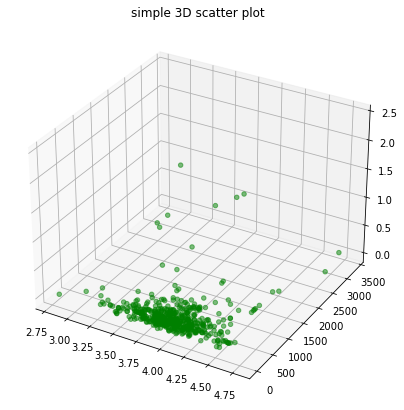

In [41]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(db.loc[1:500, 'average_rating'], db.loc[1:500, 'num_pages'], db.loc[1:500, 'ratings_count'], color = "green", alpha=0.5)
plt.title("simple 3D scatter plot")

In [42]:
# указываем количество сохраненных компонент

pca = PCA(n_components=2) 
X2D = pca.fit_transform(db[['average_rating', 'num_pages', 'ratings_count']])

In [43]:
X2D

array([[ 2.07734213e+06,  1.76915926e+02],
       [ 2.13481915e+06,  3.91293844e+02],
       [-1.20148820e+04,  8.58203378e+00],
       ...,
       [-1.75278780e+04,  7.19293492e+01],
       [-1.75788768e+04,  9.09325112e+01],
       [-1.82348871e+04, -7.10261045e+01]])

In [44]:
# дисперсия, которую объясняют наши компоненты

pca.explained_variance_ratio_  

array([9.99995615e-01, 4.38529562e-06])

# Факторный анализ

In [45]:
! pip install factor_analyzer

In [46]:
from factor_analyzer import FactorAnalyzer

In [47]:
# количественные признаки

db_f = db[['average_rating', 'num_pages', 'ratings_count']] 

Сначала надо провести тест на возможность применения факторного анализа. 

Два основных теста:

1) Bartlett’s Test

2) Kaiser-Meyer-Olkin Test


In [48]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(db_f)
chi_square_value, p_value

(361.79861008986325, 2.0728770904901877e-78)

Наше p-value (второй столбец) показывает статистическую значимость теста, а значит мы можем продолжить факторный анализ.

In [49]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(db_f)
kmo_model

0.5082998418407513

Здесь значение должно быть от 0,6 и выше. У нас это не выполняется. Однако мы продолжим анализ.

In [50]:
# вращение осей

fa = FactorAnalyzer(rotation='varimax')
fa.fit(db_f, 3)
ev, v = fa.get_eigenvalues()
ev

array([1.18793058, 0.98676895, 0.82530047])

In [51]:
print(fa.loadings_)

[[0.38840699 0.17333818 0.        ]
 [0.40989283 0.08716909 0.        ]
 [0.04309694 0.14241087 0.        ]]


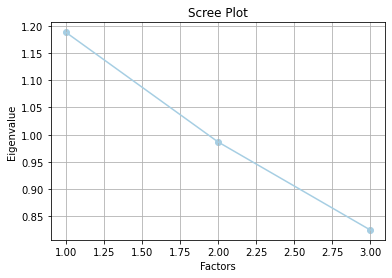

In [52]:
plt.scatter(range(1,db_f.shape[1]+1),ev)
plt.plot(range(1,db_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

Для выбора количества факторов необходимо взять только те факторы, для которых собственные значения по оси y больше 1. У нас это только один фактор, но и второй приближается к этому значению. Возьмем также и его. 

In [53]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(db_f)
ev, v = fa.get_eigenvalues()
ev

array([1.18793058, 0.98676895, 0.82530047])

In [54]:
fa.get_factor_variance()

(array([0.32072947, 0.05792543]),
 array([0.10690982, 0.01930848]),
 array([0.10690982, 0.1262183 ]))

In [55]:
print(pd.DataFrame(fa.loadings_,index=db_f.columns))

                       0         1
average_rating  0.388407  0.173338
num_pages       0.409893  0.087169
ratings_count   0.043097  0.142411


Чем ближе к 1, тем больше фактор может объяснить признак. У нас таких значений нет.